In [2]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

base_path = "/Users/manyasharma/FINAL_PROJECT_(POLYP)"  

output_base = os.path.join(base_path, "spectrograms")
os.makedirs(output_base, exist_ok=True)

classes = ["Healthy", "Polyp"]  

for cls in classes:
    input_folder = os.path.join(base_path, cls)
    output_folder = os.path.join(output_base, cls)
    os.makedirs(output_folder, exist_ok=True)

    for file in os.listdir(input_folder):
        if file.endswith(".wav"):
            file_path = os.path.join(input_folder, file)
            try:
                y, sr = librosa.load(file_path, sr=None)

                D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
                S_db = librosa.amplitude_to_db(D, ref=np.max)
                
                plt.figure(figsize=(4,4))
                librosa.display.specshow(
                    S_db,
                    sr=sr,
                    x_axis='time',
                    y_axis='linear',   
                    cmap='inferno'
                )
                plt.axis('off')
                image_save_path = os.path.join(output_folder, file.replace(".wav", ".png"))
                plt.savefig(image_save_path, bbox_inches='tight', pad_inches=0)
                plt.close()

                print(f"Saved {image_save_path}")

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

Saved /Users/manyasharma/FINAL_PROJECT_(POLYP)/spectrograms/Healthy/1-i_l.png
Saved /Users/manyasharma/FINAL_PROJECT_(POLYP)/spectrograms/Healthy/4-a_h.png
Saved /Users/manyasharma/FINAL_PROJECT_(POLYP)/spectrograms/Healthy/2200-u_l.png
Saved /Users/manyasharma/FINAL_PROJECT_(POLYP)/spectrograms/Healthy/27-a_lhl.png
Saved /Users/manyasharma/FINAL_PROJECT_(POLYP)/spectrograms/Healthy/16-phrase.png
Saved /Users/manyasharma/FINAL_PROJECT_(POLYP)/spectrograms/Healthy/27-u_h.png
Saved /Users/manyasharma/FINAL_PROJECT_(POLYP)/spectrograms/Healthy/14-i_lhl.png
Saved /Users/manyasharma/FINAL_PROJECT_(POLYP)/spectrograms/Healthy/2200-iau.png
Saved /Users/manyasharma/FINAL_PROJECT_(POLYP)/spectrograms/Healthy/17-a_h.png
Saved /Users/manyasharma/FINAL_PROJECT_(POLYP)/spectrograms/Healthy/12-i_l.png
Saved /Users/manyasharma/FINAL_PROJECT_(POLYP)/spectrograms/Healthy/12-a_lhl.png
Saved /Users/manyasharma/FINAL_PROJECT_(POLYP)/spectrograms/Healthy/3-u_n.png
Saved /Users/manyasharma/FINAL_PROJECT_(PO

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [4]:
data_dir = "/Users/manyasharma/FINAL_PROJECT_(POLYP)/spectrograms"

img_size = (128, 128)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

print("Classes:", train_generator.class_indices)

Found 448 images belonging to 2 classes.
Found 112 images belonging to 2 classes.
Classes: {'Healthy': 0, 'Polyp': 1}


In [5]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 1.0, 1: 1.0}


In [6]:
model = Sequential()
model.add(Conv2D(128, (3,3), activation='relu', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 899,938 (3.43 MB)

 Trainable params: 899,490 (3.43 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights
)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.7424 - loss: 0.5186 - val_accuracy: 0.5000 - val_loss: 2.4379
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.7244 - loss: 0.5509 - val_accuracy: 0.5000 - val_loss: 1.9471
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.7132 - loss: 0.5364 - val_accuracy: 0.5000 - val_loss: 1.9464
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.7556 - loss: 0.5122 - val_accuracy: 0.5000 - val_loss: 1.9689
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.7193 - loss: 0.5596 - val_accuracy: 0.5089 - val_loss: 1.5394
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.7090 - loss: 0.5321 - val_accuracy: 0.5268 - val_loss: 1.4582
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.7524 - loss: 0.5024 - val_accuracy: 0.5536 - val_loss: 1.1346
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - accuracy: 0.7614 - loss: 0.5326 - val_accuracy: 0.

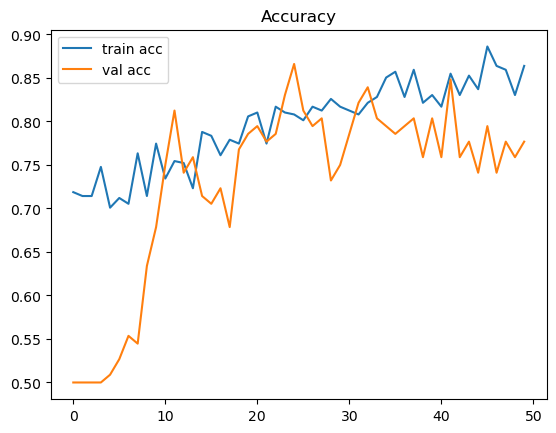

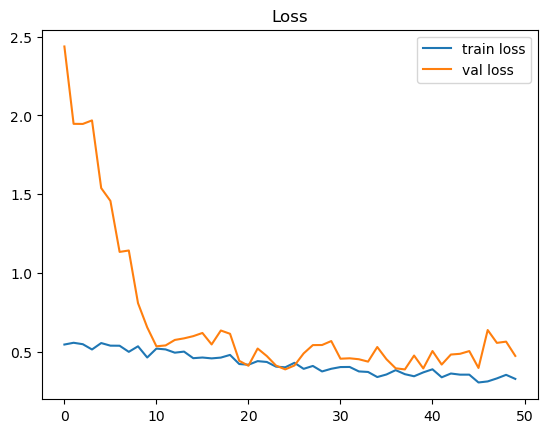

In [10]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Confusion Matrix:
 [[29 27]
 [19 37]]


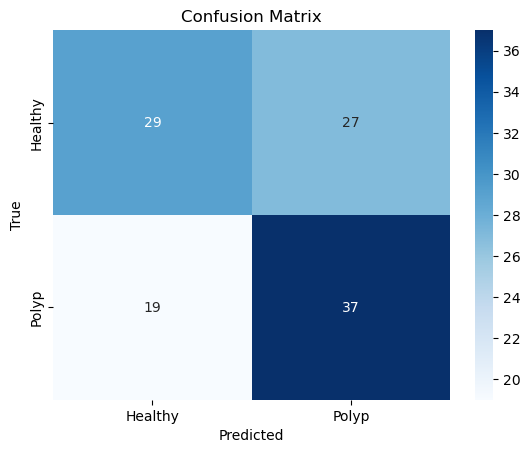

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.60      0.52      0.56        56
       Polyp       0.58      0.66      0.62        56

    accuracy                           0.59       112
   macro avg       0.59      0.59      0.59       112
weighted avg       0.59      0.59      0.59       112



In [11]:
val_generator.reset()
Y_true = val_generator.classes
Y_pred = model.predict(val_generator, verbose=1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(Y_true, Y_pred_classes)
print("Confusion Matrix:\n", cm)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(Y_true, Y_pred_classes, target_names=val_generator.class_indices.keys()))

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [13]:
data_dir = "/Users/manyasharma/FINAL_PROJECT_(POLYP)/spectrograms"

img_size = (224, 224)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

Found 448 images belonging to 2 classes.
Found 112 images belonging to 2 classes.


In [14]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  

In [15]:
from tensorflow.keras.layers import Flatten

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
optimizer = Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4945 - loss: 0.7883 - val_accuracy: 0.4821 - val_loss: 0.7083
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4805 - loss: 0.7575 - val_accuracy: 0.4911 - val_loss: 0.6958
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5472 - loss: 0.7342 - val_accuracy: 0.4911 - val_loss: 0.7007
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5447 - loss: 0.6992 - val_accuracy: 0.4286 - val_loss: 0.7003
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5350 - loss: 0.7332 - val_accuracy: 0.4911 - val_loss: 0.7002
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5342 - loss: 0.7141 - val_accuracy: 0.5625 - val_loss: 0.6930
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5499 - loss: 0.7127 - val_accuracy: 0.5268 - val_loss: 0.6893
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5590 - loss: 0.7043 - val_accuracy: 0.5446 - val_loss: 0.6869
Epo

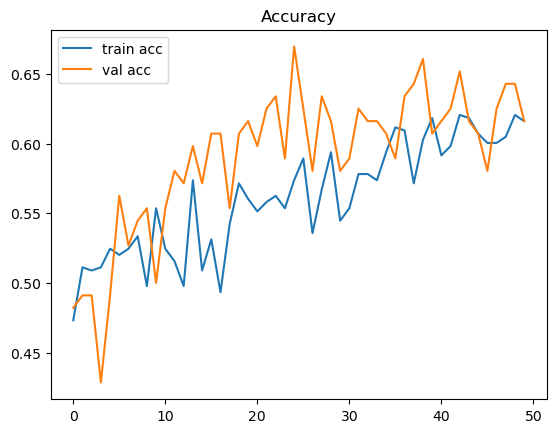

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


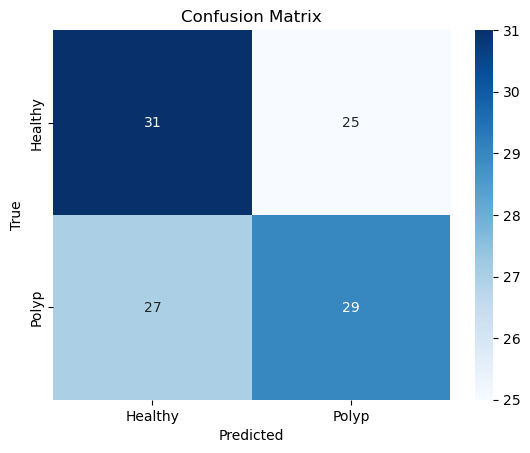

              precision    recall  f1-score   support

     Healthy       0.53      0.55      0.54        56
       Polyp       0.54      0.52      0.53        56

    accuracy                           0.54       112
   macro avg       0.54      0.54      0.54       112
weighted avg       0.54      0.54      0.54       112



In [18]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy")
plt.show()

val_generator.reset()
Y_true = val_generator.classes
Y_pred = model.predict(val_generator, verbose=1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(Y_true, Y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(Y_true, Y_pred_classes, target_names=val_generator.class_indices.keys()))